<a href="https://colab.research.google.com/github/Rorodino/homework-4-Rorodino/blob/main/Copy_of_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4
1.  Consider the logistic curve
$$
f(x) = \frac{e^{\beta_0 + \beta_1x}}{1 + e^{\beta_0 + \beta_1 x}}.
$$
Plot the curve for various values of $\beta_0$ and $\beta_1$ to see how changing $\beta_0$ and $\beta_1$ impact the curve.
2.Consider the diamond dataset from [here](https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv). The documentation for the dataset can be found [here](https://lbelzile.github.io/lineaRmodels/example-price-of-diamonds.html). Fit a linear model with price as the outcome, carat, cut, color and clarity as predictors. For the variables that are not numeric (cut for example), [one hot encode them](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). Break your data into (around 25%) testing and (around 75%) training data and evaluate the square root of the mean squared error on your testing data. Use any python function library that you'd like.   
3. Consider the covid data analyzed previously. Consider a country. Let $Z_i$ be the case count for day $i$ from the first infection. Let $Y_i$ be an indicator of whether a country's case count went strictly up or down on day $i$. That is, $Y_i = 1$ if $Z_i > Z_{i-1}$ and $Y_i = 0$ if $Z_i \leq Z_{i-1}$. Consider the logit model
$$
\mathrm{logit}\{P(Y_i = 1)\} = \beta_0 + \beta_1 Z_{i-1} + \beta_2 Z_{i-2} + \beta_3 Z_{i-3} + \beta_4 Z_{i-4}
$$
In other words, does the previous four days case values predict whether or not the number of cases will go up or down tomorrow? Perform a validation in two ways. Train on the first 75% of days for a country and then consider the accuracy on the last 25%. Call this the within country forecasting accuracy. Secondly, train on 100% of the days for one country and consider the accuracy when applied to a second country. Call this the between country forecasting accuracy. In both cases, calculate the accuracy for a 0.50 threshold.


In [ ]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

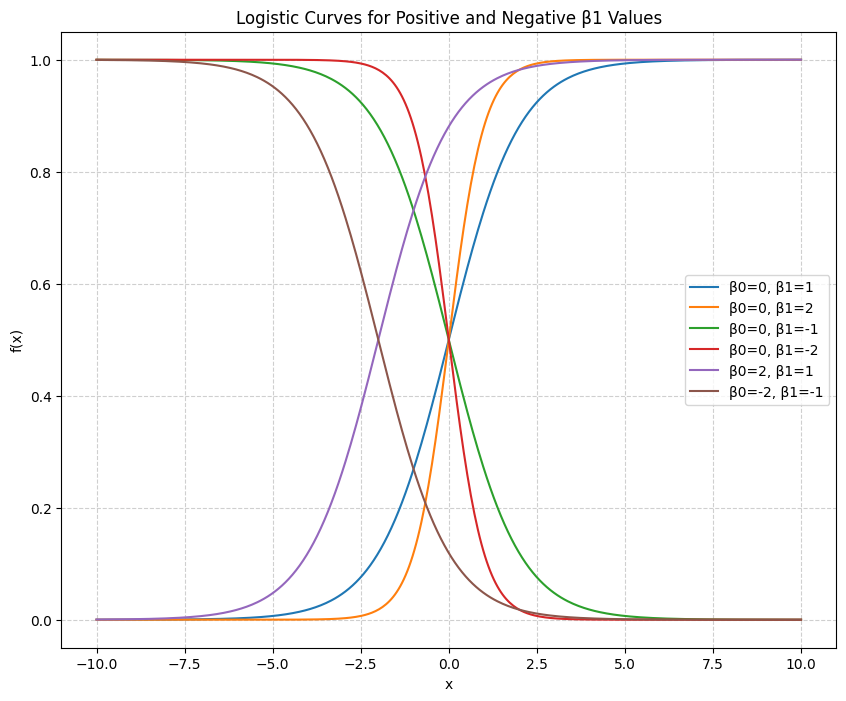

In [ ]:
#Question 1a
#The x that is inputted so we can generate y-values and graph
x = np.linspace(-10, 10, 400)

# Parameter sets
parameters = [
    (0, 1),   # standard logistic (increasing)
    (0, 2),   # steeper increasing
    (0, -1),  # decreasing logistic
    (0, -2),  # steeper decreasing
    (2, 1),   # shifted right, increasing
    (-2, -1)  # shifted left, decreasing
]

plt.figure(figsize=(10, 8))
for b0, b1 in parameters:
    y = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    plt.plot(x, y, label=f'β0={b0}, β1={b1}')

# Plot styling
plt.title("Logistic Curves for Positive and Negative β1 Values")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
# Load data
diamonds = sns.load_dataset("diamonds")

# Select predictors and outcome
X = diamonds[["carat", "cut", "color", "clarity"]]
y = diamonds["price"]

# One-hot encode
X = pd.get_dummies(X, drop_first=True)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit linear model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 1151.8950726706287


In [ ]:
#Question 2:

# Load COVID-19 data
df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/"
    "csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)


# Function to extract Z_i and Y_i
def find_Zi(df, country):
    """Return lagged features X (Z_{i-1}..Z_{i-4}) and binary target Y_i for a country."""
    country_data = df[df['Country/Region'] == country].iloc[:, 4:]
    country_data = country_data.sum()  # sum over provinces/states
    z = np.array(country_data)

    # Target: 1 if cases increased, 0 otherwise
    y = (z[1:] > z[:-1]).astype(int)

    # Build lag features
    x = np.zeros((len(z)-1, 4))
    for i in range(len(z)-1):
        x[i, 0] = z[i]                 # Z_{i-1}
        x[i, 1] = z[i-1] if i-1 >= 0 else 0
        x[i, 2] = z[i-2] if i-2 >= 0 else 0
        x[i, 3] = z[i-3] if i-3 >= 0 else 0

    # Remove first 4 rows since lagged features start at index 4
    x = x[4:]
    y = y[4:]

    return x, y


# Within-country accuracy
def within_country_accuracy(df, country):
    X, Y = find_Zi(df, country)
    index = int(0.75 * len(Y))
    X_train, X_test = X[:index], X[index:]
    Y_train, Y_test = Y[:index], Y[index:]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, Y_train)

    Y_pred = (model.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    return accuracy_score(Y_test, Y_pred)

# Between-country accuracy
def between_country_accuracy(df, train_country, test_country):
    X_train, Y_train = find_Zi(df, train_country)
    X_test, Y_test = find_Zi(df, test_country)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, Y_train)

    Y_pred = (model.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    return accuracy_score(Y_test, Y_pred)

# Run evaluations
country_train = 'US'
country_test = 'Italy'

within_acc = within_country_accuracy(df, country_train)
between_acc = between_country_accuracy(df, country_train, country_test)

print(f"Within-country forecasting accuracy ({country_train}): {within_acc:.4f}")
print(f"Between-country forecasting accuracy (train={country_train}, test={country_test}): {between_acc:.4f}")


Within-country forecasting accuracy (US): 0.9965
Between-country forecasting accuracy (train=US, test=Italy): 0.9455
